# 1. Preparation

Load the data and do some process.

In [1]:
import pandas as pd
import numpy as np
from helper_functions import *

RANDOM_SEED = 42

cleaned_df = processing_data(path="C:\\Users\\lee39\\OneDrive\\Desktop\\final_merged_dataset.csv")

C:\My_Programs\Anaconda\envs\CSMDRMP\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35489 entries, 0 to 35488
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            35489 non-null  object 
 1   age               35489 non-null  int64  
 2   ethnicity         35489 non-null  object 
 3   admission_type    35489 non-null  object 
 4   event             35489 non-null  int32  
 5   time              35489 non-null  int64  
 6   has_COPD          35489 non-null  float64
 7   has_Diabetes      35489 non-null  float64
 8   has_Metastasis    35489 non-null  float64
 9   has_Sepsis_A41_9  35489 non-null  float64
 10  GCS               35489 non-null  float64
 11  vent              35489 non-null  float64
 12  treatment         35489 non-null  float64
 13  WBC x 1000        35489 non-null  float64
 14  Hgb               35489 non-null  float64
 15  platelets x 1000  35489 non-null  float64
 16  total bilirubin   35489 non-null  float6

In [3]:
categorical_features = ["gender",
                    "ethnicity",
                    "admission_type",
                    "has_COPD",
                    "has_Diabetes",
                    "has_Metastasis",
                    "has_Sepsis_A41_9"]


# 2. DCM on eICU

Process the data so that DCM can be trained on them.

In [4]:
X_data, t_data, e_data, categorical_features_list, numerical_features_list = (
    processing_data_2_DCM(df=cleaned_df,
                          categorical_features_list=categorical_features,
                          train_test_val_size=(0.7, 0.2, 0.1),
                          random_seed=RANDOM_SEED)
)
X_train, X_val, X_test = X_data
t_train, t_val, t_test = t_data
e_train, e_val, e_test = e_data

Define model hyper-parameters.

In [5]:
from sklearn.model_selection import ParameterGrid

param_grid = {'k' : [3],
              'learning_rate' : [1e-3],
              'layers' : [[50, 50] ]
             }
params = ParameterGrid(param_grid)

Train the DCM.

In [6]:
from auton_survival.models.dcm import DeepCoxMixtures

model = DeepCoxMixtures(random_seed=RANDOM_SEED)

# The fit method is called to train the model
model.fit(X_train, t_train, e_train, iters=100, val_data=(X_val, t_val, e_val))

  0%|          | 0/100 [00:00<?, ?it/s]C:\My_Programs\Anaconda\envs\CSMDRMP\lib\site-packages\auton_survival\models\dcm\dcm_utilities.py:105: RuntimeWarning: invalid value encountered in log
  probs = gates+np.log(event_probs)
C:\My_Programs\Anaconda\envs\CSMDRMP\lib\site-packages\auton_survival\models\dcm\dcm_utilities.py:105: RuntimeWarning: divide by zero encountered in log
  probs = gates+np.log(event_probs)
 23%|██▎       | 23/100 [00:46<02:36,  2.04s/it]


Find the latent group for the training data

In [7]:
train_latent = model.predict_latent_z(X_train)

train_group = np.argmax(train_latent, axis=1)
train_group

array([0, 0, 1, ..., 0, 0, 0], dtype=int64)

Compute propensity score and IPTW

In [8]:
# get the name of covariates exclude the treatment
covariates = list(X_train.columns.drop("treatment_1.0"))

df_ps = pd.concat([X_train, t_train, e_train], axis=1)
df_ps = compute_PS_and_IPTW(df=df_ps,
                            covariates=covariates,
                            treatment="treatment_1.0")

Plot the survival curve and estimate causal using AUC

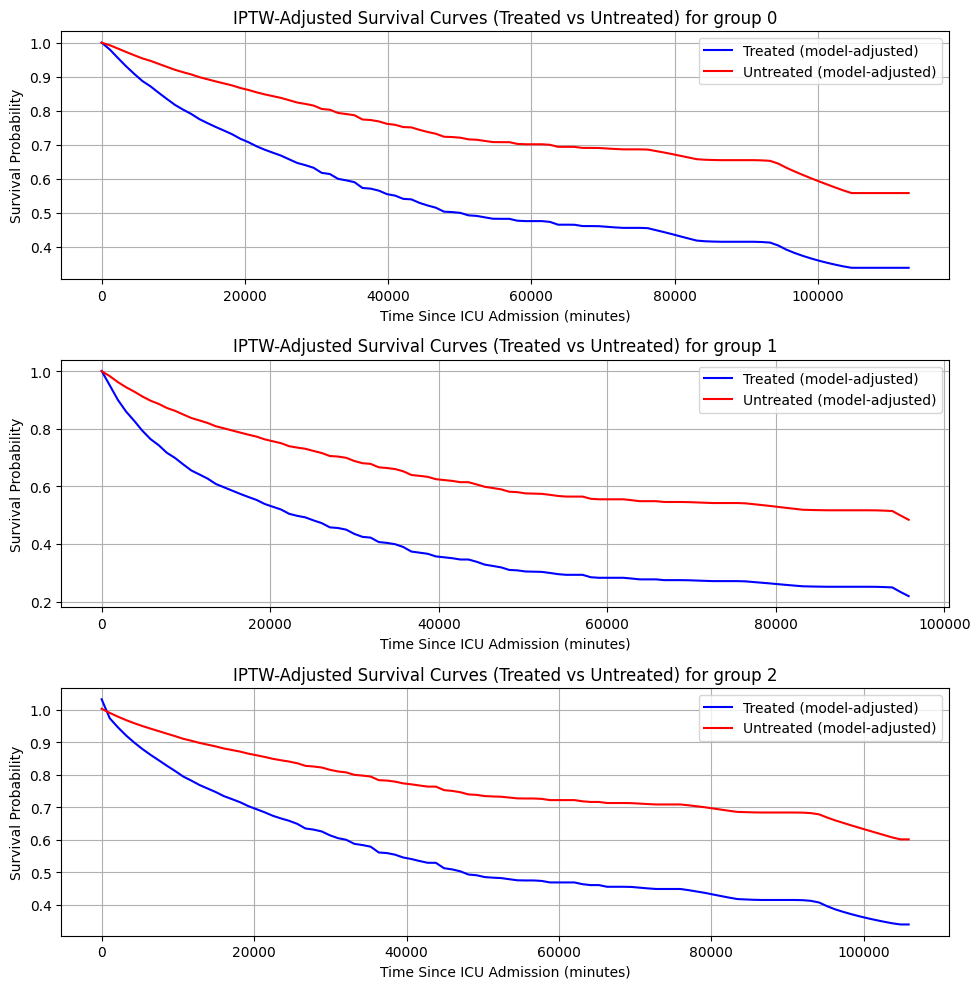

In [9]:
causal_effects = plot_DCM_avg_survival_curve(df_ps=df_ps,
                            group_index=train_group,
                            model=model,
                            covariates=covariates,
                            treatment="treatment_1.0"
                            )

In [14]:
for i, ce in enumerate(causal_effects):
    print(f"For group {i}, the estimated causal effect: {ce}.")

For group 0, the estimated causal effect: -22096.09348343064
For group 1, the estimated causal effect: -23224.928639672064
For group 2, the estimated causal effect: -23062.675143177337
